#  <center>names 数据集</center>

# 数据内容
一份从1880年到2010年的全美国婴儿名字频率数据。

# 目标
* 计算指定名字的年度比例
* 计算某个名字的相对排名
* 计算各年度最流行的名字，以及增长或减少最快的名字

### 0 准备工作

In [1]:
%pwd

u'D:\\GitClone\\kayle_Note\\Data Analysis\\\u5229\u7528Python\u8fdb\u884c\u6570\u636e\u5206\u6790\\chapter02\\code'

In [2]:
%cd ../data/names/

D:\GitClone\kayle_Note\Data Analysis\利用Python进行数据分析\chapter02\data\names


### 设置工作路径

In [3]:
path1880 = './yob1880.txt'

In [4]:
from __future__ import division
from numpy.random import randn
import numpy as np
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 5))
np.set_printoptions(precision=4)

In [5]:
!head -n 10  yob1880.txt

Mary,F,7065
Anna,F,2604
Emma,F,2003
Elizabeth,F,1939
Minnie,F,1746
Margaret,F,1578
Ida,F,1472
Alice,F,1414
Bertha,F,1320
Sarah,F,1288


用pandas.read_csv 将其加载到DataFrame中：

In [6]:
import pandas as pd
names1880 = pd.read_csv(path1880, names=['name', 'sex', 'births'])
names1880

,name,sex,births
0,Mary,F,7065
1,Anna,F,2604
2,Emma,F,2003
3,Elizabeth,F,1939
4,Minnie,F,1746
5,Margaret,F,1578
6,Ida,F,1472
7,Alice,F,1414
8,Bertha,F,1320
9,Sarah,F,1288


In [7]:
names1880.groupby('sex').births.sum()

sex
F     90993
M    110493
Name: births, dtype: int64

由于整个数据集是按照年度被分隔成了多个文件，所以第一件事情就是要将所有的数据都组装到一个DataFrame里面，并加上一个year字段

In [8]:
# 2010s是目前最后一个有效统计年度
years = range(1880, 2011)

pieces = []
columns = ['name', 'sex', 'births']

# 循环读取数据
for year in years:
    path = './yob{y}.txt'.format(y=year)
    frame = pd.read_csv(path, names=columns)
    
    # 添加一个year字段
    frame['year'] = year
    pieces.append(frame)
    
# 将所有数据整合到单个DataFrame中
names = pd.concat(pieces, ignore_index=True)

In [9]:
names

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880
5,Margaret,F,1578,1880
6,Ida,F,1472,1880
7,Alice,F,1414,1880
8,Bertha,F,1320,1880
9,Sarah,F,1288,1880


利用groupby或pivot_table在year和sex级别上对其进行聚合

In [10]:
total_births = names.pivot_table('births', index='year', columns='sex', aggfunc=sum)

In [11]:
total_births.tail()

sex,F,M
year,,
2006,1896468,2050234
2007,1916888,2069242
2008,1883645,2032310
2009,1827643,1973359
2010,1759010,1898382


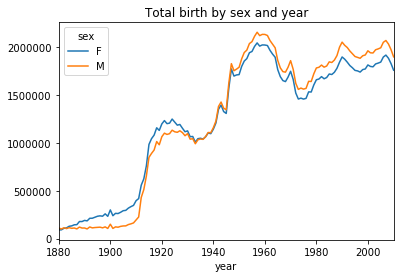

In [12]:
total_births.plot(title='Total birth by sex and year')

插入一个prop列，用于存放指定名字的婴儿数相对总出生数的比例

In [13]:
def add_prop(group):
    # 整数除法会向下取整
    births = group.births.astype(float)
    
    group['prop'] = births / births.sum()
    return group
names = names.groupby(['year', 'sex']).apply(add_prop)

In [14]:
names

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077643
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
5,Margaret,F,1578,1880,0.017342
6,Ida,F,1472,1880,0.016177
7,Alice,F,1414,1880,0.015540
8,Bertha,F,1320,1880,0.014507
9,Sarah,F,1288,1880,0.014155


对分组进行有限性检查

In [15]:
np.allclose(names.groupby(['year', 'sex']).prop.sum(), 1)

True

为了便于实现更进一步的分析，取出该数据的子集：每队sex/year组合的前1000个名字

In [16]:
def get_top1000(group):
    return group.sort_values(by='births', ascending=False)[:1000]

grouped = names.groupby(['year', 'sex'])
top1000 = grouped.apply(get_top1000)

In [17]:
top1000.index = np.arange(len(top1000))

In [18]:
top1000

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077643
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
5,Margaret,F,1578,1880,0.017342
6,Ida,F,1472,1880,0.016177
7,Alice,F,1414,1880,0.015540
8,Bertha,F,1320,1880,0.014507
9,Sarah,F,1288,1880,0.014155


接下来的数据分析工作就针对这个top1000数据集

### 分析命名趋势

In [19]:
boys = top1000[top1000.sex == 'M']
girls = top1000[top1000.sex == 'F']

生成一张按year和name统计的总出生数透视图

In [20]:
total_births = top1000.pivot_table('births', index='year', columns='name', aggfunc=sum)

In [21]:
total_births

name,Aaden,Aaliyah,Aarav,Aaron,Aarush,Ab,Abagail,Abb,Abbey,Abbie,...,Zoa,Zoe,Zoey,Zoie,Zola,Zollie,Zona,Zora,Zula,Zuri
year,,,,,,,,,,,,,,,,,,,,,
1880,NaN,NaN,NaN,102.0,NaN,NaN,NaN,NaN,NaN,71.0,...,8.0,23.0,NaN,NaN,7.0,NaN,8.0,28.0,27.0,NaN
1881,NaN,NaN,NaN,94.0,NaN,NaN,NaN,NaN,NaN,81.0,...,NaN,22.0,NaN,NaN,10.0,NaN,9.0,21.0,27.0,NaN
1882,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,80.0,...,8.0,25.0,NaN,NaN,9.0,NaN,17.0,32.0,21.0,NaN
1883,NaN,NaN,NaN,105.0,NaN,NaN,NaN,NaN,NaN,79.0,...,NaN,23.0,NaN,NaN,10.0,NaN,11.0,35.0,25.0,NaN
1884,NaN,NaN,NaN,97.0,NaN,NaN,NaN,NaN,NaN,98.0,...,13.0,31.0,NaN,NaN,14.0,6.0,8.0,58.0,27.0,NaN
1885,NaN,NaN,NaN,88.0,NaN,6.0,NaN,NaN,NaN,88.0,...,6.0,27.0,NaN,NaN,12.0,6.0,14.0,48.0,38.0,NaN
1886,NaN,NaN,NaN,86.0,NaN,NaN,NaN,NaN,NaN,84.0,...,13.0,25.0,NaN,NaN,8.0,NaN,20.0,52.0,43.0,NaN
1887,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,104.0,...,9.0,34.0,NaN,NaN,23.0,NaN,28.0,46.0,33.0,NaN
1888,NaN,NaN,NaN,90.0,NaN,NaN,NaN,NaN,NaN,137.0,...,11.0,42.0,NaN,NaN,23.0,7.0,30.0,42.0,45.0,NaN


用DataFrame的plot方法绘制几个名字的曲线图

In [23]:
subset = total_births[['John', 'Harry', 'Mary', 'Marilyn']]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000018973BE0>,
      dtype=object)

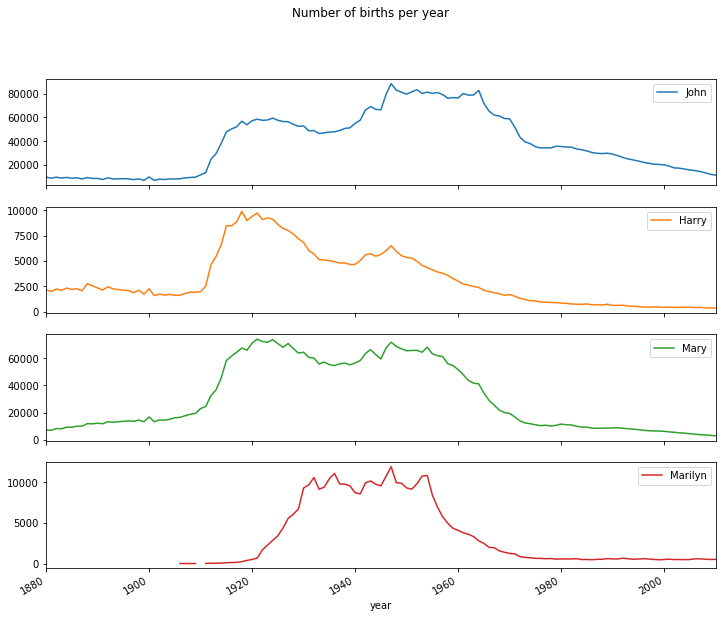

In [24]:
subset.plot(subplots=True, figsize=(12, 10), grid=False, title='Number of births per year')

### 评估命名多样性的增长

In [25]:
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

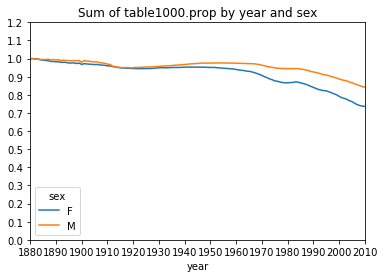

In [26]:
table = top1000.pivot_table('prop', index='year',
                            columns='sex', aggfunc=sum)
table.plot(title='Sum of table1000.prop by year and sex',
           yticks=np.linspace(0, 1.2, 13), xticks=range(1880, 2020, 10))

In [27]:
df = boys[boys.year == 2010]
df

,name,sex,births,year,prop
260877,Jacob,M,21875,2010,0.011523
260878,Ethan,M,17866,2010,0.009411
260879,Michael,M,17133,2010,0.009025
260880,Jayden,M,17030,2010,0.008971
260881,William,M,16870,2010,0.008887
260882,Alexander,M,16634,2010,0.008762
260883,Noah,M,16281,2010,0.008576
260884,Daniel,M,15679,2010,0.008259
260885,Aiden,M,15403,2010,0.008114
260886,Anthony,M,15364,2010,0.008093


In [29]:
prop_cumsum = df.sort_values(by='prop', ascending=False).prop.cumsum()
prop_cumsum[:10]

260877    0.011523
260878    0.020934
260879    0.029959
260880    0.038930
260881    0.047817
260882    0.056579
260883    0.065155
260884    0.073414
260885    0.081528
260886    0.089621
Name: prop, dtype: float64

In [30]:
prop_cumsum.values.searchsorted(0.5)

116

In [32]:
df = boys[boys.year == 1900]
in1900 = df.sort_values(by='prop', ascending=False).prop.cumsum()
in1900.values.searchsorted(0.5) + 1

25

In [34]:
def get_quantile_count(group, q=0.5):
    group = group.sort_values(by='prop', ascending=False)
    return group.prop.cumsum().values.searchsorted(q) + 1

diversity = top1000.groupby(['year', 'sex']).apply(get_quantile_count)
diversity = diversity.unstack('sex')

In [35]:
diversity.head()

sex,F,M
year,,
1880,38,14
1881,38,14
1882,38,15
1883,39,15
1884,39,16


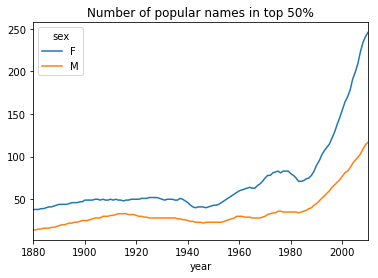

In [36]:
diversity.plot(title="Number of popular names in top 50%")

从图中可以看出，女孩名字多样性总是比男孩子高，而且还在变得越来越高。